In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
#Check number of prefectures in data
prefectures = pd.read_csv('prefecture_code.csv')
prefectures.head()

,Code,JpName,EnName
0,1,北海道,Hokkaido
1,2,青森県,Aomori
2,3,岩手県,Iwate
3,4,宮城県,Miyagi
4,5,秋田県,Akita


A total of 47 prefectures is in the trade_prices csv files, from this we're going to check the number of columns and what might be relevant

In [3]:
#Opening of one of the trade_prices csv file
df = pd.read_csv('trade_prices//01.csv')
df.head()

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (12,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28.0,...,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,NaN
1,2,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,NaN
2,3,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20.0,...,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,4th quarter 2018,2018,4,Not yet,NaN
3,4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26.0,...,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,NaN
4,5,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,NaN


In [4]:
print(df.shape)
print(df.columns)

(186238, 38)
Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'FloorPlan', 'Area',
       'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding',
       'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks'],
      dtype='object')


From this, it appears that the dataset contains 38 columns and 186238 entries. It can also be noted that the prefecture has not been edited to its prefecture code. All data would now then be loaded into a single pandas DataFrame

In [5]:
df.drop(df.index, inplace=True)
#Describing dtype in each of the column 
df = pd.concat((pd.read_csv(file, dtype={
    'No': 'int64',  'Type': 'category', 'Region': 'category', 'MunicipalityCode': 'category', 'Prefecture': 'category',
    'Municipality': 'category', 'DistrictName': 'category', 'NearestStation': 'category', 'TimeToNearestStation': 'string',
    'MinTimeToNearestStation': 'string', 'MaxTimeToNearestStation': 'string', 'TradePrice': 'float', 'FloorPlan': 'category',
    'Area': 'float', 'AreaIsGreaterFlag': 'bool', 'UnitPrice': 'float', 'PricePerTsubo': 'float', 'LandShape': 'category',
    'Frontage': 'float', 'FrontageIsGreaterFlag': 'bool', 'TotalFloorArea': 'float', 'TotalFloorAreaIsGreaterFlag': 'float',
    'BuildingYear': 'float', 'PrewarBuilding': 'bool', 'Structure': 'category', 'Use': 'category', 'Purpose': 'category',
    'Direction': 'category', 'Classification': 'category', 'Breadth': 'float', 'CityPlanning': 'category',
    'CoverageRatio': 'float', 'FloorAreaRatio': 'float', 'Period': 'category', 'Year': 'int64', 'Quarter': 'int64',
    'Renovation': 'category', 'Remarks': 'string'
}) for file in glob('trade_prices/*.csv')), ignore_index=True)

In [6]:
df.head()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,...,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,<NA>
1,2,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,<NA>
2,3,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,...,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,4th quarter 2018,2018,4,Not yet,<NA>
3,4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,...,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,<NA>
4,5,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,<NA>


From the following columns, the column 'No' can be omitted from the dataset as it would have no purpose on the prediction of real estate prices

As TimeToNearestStation and MinTime and MaxTime ToNearestStation is related to each other where TimeToNearestStation would be a string in which it describes the time range when one could reach the nearest station, this column is also omitted

As the 'Period' Column only pertains to the 'Quarter' Columns, this column can also be removed

The 'Remarks' Column is rarely used, this column is also removed from the dataset.

# Removal of Initial Data & Null Values

In [7]:
df.drop(columns=['No','TimeToNearestStation', 'Period', 'Remarks'], inplace=True)
df.head()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,...,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation
0,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,...,Other,South,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4,NaN
1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,...,House,East,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4,NaN
2,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,...,House,NaN,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,2018,4,Not yet
3,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,...,NaN,West,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2,NaN
4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,...,House,West,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2,NaN


In [8]:
#Shows number of missing data in each of the column
print(df.isnull().sum())
print(df.shape)

Type                                 0
Region                         1117077
MunicipalityCode                     0
Prefecture                           0
Municipality                         0
DistrictName                      8275
NearestStation                  565811
MinTimeToNearestStation         590541
MaxTimeToNearestStation         678447
TradePrice                           0
FloorPlan                      3309348
Area                                 0
AreaIsGreaterFlag                    0
UnitPrice                      2522103
PricePerTsubo                  2522103
LandShape                      1127530
Frontage                       1369455
FrontageIsGreaterFlag                0
TotalFloorArea                 2588858
TotalFloorAreaIsGreaterFlag          0
BuildingYear                   2036714
PrewarBuilding                       0
Structure                      1993945
Use                            2020044
Purpose                        2723740
Direction                

Columns in which more than 1 million records of data is missing would be omitted, the following columns are:
- Floor Plan
- Structure
- Use
- Purpose
- Renovation
- Region
- Unit Price
- PricePerTsubo
- LandShape
- Frontage
- TotalFloorArea
- BuildingYear
- Structure
- Use
- Purpose
- Direction
- Classification
- Breadth

In [9]:
df.drop(columns=['FloorPlan','Structure', 'Use', 'Purpose', 'Renovation', 'Region' ,'UnitPrice',
                'PricePerTsubo', 'LandShape', 'Frontage', 'TotalFloorArea','BuildingYear','Structure','Use',
                'Purpose','Direction','Classification','Breadth'], inplace=True)
df.head()

,Type,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,1100.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4
1,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,310.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4
2,"Pre-owned Condominiums, etc.",1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,95.0,False,False,0.0,False,Neighborhood Commercial Zone,80.0,200.0,2018,4
3,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,290.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2
4,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,430.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2


In [10]:
print(df.isnull().sum())
print(df.shape)

Type                                0
MunicipalityCode                    0
Prefecture                          0
Municipality                        0
DistrictName                     8275
NearestStation                 565811
MinTimeToNearestStation        590541
MaxTimeToNearestStation        678447
TradePrice                          0
Area                                0
AreaIsGreaterFlag                   0
FrontageIsGreaterFlag               0
TotalFloorAreaIsGreaterFlag         0
PrewarBuilding                      0
CityPlanning                   530666
CoverageRatio                  714641
FloorAreaRatio                 714641
Year                                0
Quarter                             0
dtype: int64
(3906518, 19)


The remaining data that have null values would be removed from the dataset

In [11]:
df = df.dropna()
print(df.isnull().sum())
print(df.shape)

Type                           0
MunicipalityCode               0
Prefecture                     0
Municipality                   0
DistrictName                   0
NearestStation                 0
MinTimeToNearestStation        0
MaxTimeToNearestStation        0
TradePrice                     0
Area                           0
AreaIsGreaterFlag              0
FrontageIsGreaterFlag          0
TotalFloorAreaIsGreaterFlag    0
PrewarBuilding                 0
CityPlanning                   0
CoverageRatio                  0
FloorAreaRatio                 0
Year                           0
Quarter                        0
dtype: int64
(3077722, 19)


From this, it appears that approximately 3.07 million records would be used for the training and testing of the dataset.

The model would be attempting to predict the TradePrice column based on the values of the other columns.

# Removal of TradePrice == 0

# Checking for Correlated Columns

In [12]:
#Know correlation between data, data that has a correlation value of more than 0.5 would have one of the columns be omitted
df.corr()

,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CoverageRatio,FloorAreaRatio,Year,Quarter
TradePrice,1.000000,0.183885,0.181598,0.136064,0.288844,0.000520,0.041112,0.082946,-0.012940,-0.007162
Area,0.183885,1.000000,0.681670,0.463064,0.197990,0.000736,-0.055481,-0.099257,0.014769,0.000479
AreaIsGreaterFlag,0.181598,0.681670,1.000000,0.492015,0.204042,0.000681,-0.000987,-0.013673,0.002282,-0.005017
FrontageIsGreaterFlag,0.136064,0.463064,0.492015,1.000000,0.151547,-0.000056,0.001691,-0.013214,0.001489,-0.004655
TotalFloorAreaIsGreaterFlag,0.288844,0.197990,0.204042,0.151547,1.000000,0.003126,0.040546,0.056547,-0.003814,-0.004928
PrewarBuilding,0.000520,0.000736,0.000681,-0.000056,0.003126,1.000000,0.011964,0.008831,-0.000389,0.000735
CoverageRatio,0.041112,-0.055481,-0.000987,0.001691,0.040546,0.011964,1.000000,0.790854,0.022179,-0.004675
FloorAreaRatio,0.082946,-0.099257,-0.013673,-0.013214,0.056547,0.008831,0.790854,1.000000,0.016625,-0.006931
Year,-0.012940,0.014769,0.002282,0.001489,-0.003814,-0.000389,0.022179,0.016625,1.000000,-0.095817
Quarter,-0.007162,0.000479,-0.005017,-0.004655,-0.004928,0.000735,-0.004675,-0.006931,-0.095817,1.000000


From the data given above, the columns
- Area : AreaIsGreaterFlag
- FloorAreaRatio : CoverageRatio

Are moderately to highly correlated, thus AreaIsGreaterFlag column and CoverageRatio would be dropped from the dataset

In [13]:
df.drop(columns=['AreaIsGreaterFlag', 'CoverageRatio'], inplace=True)
df.head()

,Type,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"Pre-owned Condominiums, etc.",1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,95.0,False,0.0,False,Neighborhood Commercial Zone,200.0,2018,4
3,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,290.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,430.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2


Now, as the data has prices of different real estates from 47 different prefectures, we want to know if there is any difference between the average prices between each of the prefectures

# Conversion of TradePrice to log2

As the trade price is heavily right skewed, TradePrice would be converted to log2 as to normalize the data

In [14]:
#Conversion of Yen to Million Yen
df['TradePrice'] = np.log2(df['TradePrice'])

In [15]:
df.shape

(3077722, 17)

In [16]:
#Evenly cut the range from the min of TradePrice to max of TradePrice to 50 separate bins
def getPriceRange(numbins):
    TPV = df['TradePrice'].value_counts(bins = numbins)
    ax = TPV.plot.bar(figsize=(15,5))
    ax.margins(y=0.01)
    ax.set_xlabel('Log2 of Price', fontsize = 15)
    ax.set_ylabel('Number of Houses', fontsize = 15)
    ax.set_title(f'Price Range', fontsize=20)
    plt.yticks(fontsize=12)
    plt.show()
    del ax, TPV

In [17]:
df.describe()

,TradePrice,Area,TotalFloorAreaIsGreaterFlag,FloorAreaRatio,Year,Quarter
count,3.077722e+06,3.077722e+06,3.077722e+06,3.077722e+06,3.077722e+06,3.077722e+06
mean,2.394286e+01,2.660970e+02,3.407715e-03,2.085705e+02,2.012905e+03,2.518370e+00
std,1.646346e+00,3.564711e+02,5.827610e-02,1.074700e+02,3.674005e+00,1.111718e+00
min,6.643856e+00,1.000000e+01,0.000000e+00,5.000000e+01,2.005000e+03,1.000000e+00
25%,2.301903e+01,8.500000e+01,0.000000e+00,2.000000e+02,2.010000e+03,2.000000e+00
50%,2.410149e+01,1.600000e+02,0.000000e+00,2.000000e+02,2.013000e+03,3.000000e+00
75%,2.497596e+01,2.600000e+02,0.000000e+00,2.000000e+02,2.016000e+03,4.000000e+00
max,3.582809e+01,2.000000e+03,1.000000e+00,1.300000e+03,2.019000e+03,4.000000e+00


With the given data, it seems that the mean and standard deviation is way too differentiated with 155 million Yen as standard deviation whereas the mean is only around 33 million yen. Any values above the first range in getPriceRange would be removed.

# Removing Outliers in the Dataset

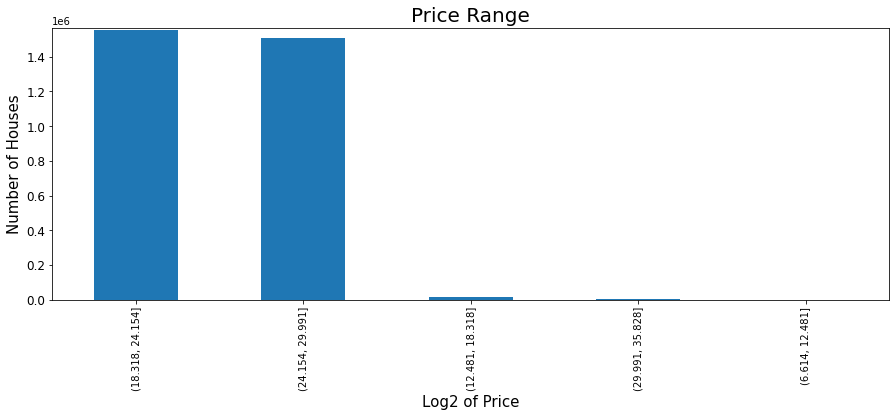

In [18]:
getPriceRange(5)

In [19]:
df.loc[df['TradePrice'] < 18.318]

,Type,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
2923,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Bankei,Maruyamakoen,30,60,15.896522,200.0,False,0.0,False,Urbanization Control Area,200.0,2019,1
2925,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Bankei,Maruyamakoen,30,60,17.457637,390.0,False,0.0,False,Urbanization Control Area,200.0,2016,4
3517,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Bankei,Hassamuminami,90,120,12.425216,990.0,False,0.0,False,Urbanization Control Area,200.0,2008,4
3675,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Fushimi,Maruyamakoen,30,60,17.194603,105.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2006,4
3697,"Pre-owned Condominiums, etc.",1101,Hokkaido,"Chuo Ward,Sapporo City",Minami2jonishi,Maruyamakoen,5,5,16.747144,25.0,False,0.0,False,Neighborhood Commercial Zone,300.0,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869561,Residential Land(Land Only),46215,Kagoshima Prefecture,Satsumasendai City,Miyazatocho,Sendai (Kagoshima),30,60,15.693705,55.0,False,0.0,False,Non-divided City Planning Area,400.0,2008,3
3870344,Residential Land(Land Only),46218,Kagoshima Prefecture,Kirishima City,Kokubuuenodan,Kokubu (Kagoshima),90,120,17.931569,95.0,False,0.0,False,Non-divided City Planning Area,400.0,2008,2
3872441,Residential Land(Land Only),46225,Kagoshima Prefecture,Aira City,Kajikichohikiyama,Kajiki,9,9,18.194603,95.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2008,3
3875443,Residential Land(Land Only),47201,Okinawa Prefecture,Naha City,Aza Nakaima,Asato,30,60,17.095067,20.0,False,0.0,False,Quasi-residential Zone,200.0,2015,3


In [20]:
df.shape

(3077722, 17)

From this, it appears that less than 0.5% is between 6.614 and 18.318 of the TradePrice, these data would then be omitted

In [21]:
df = df.loc[df['TradePrice'] > 18.318]

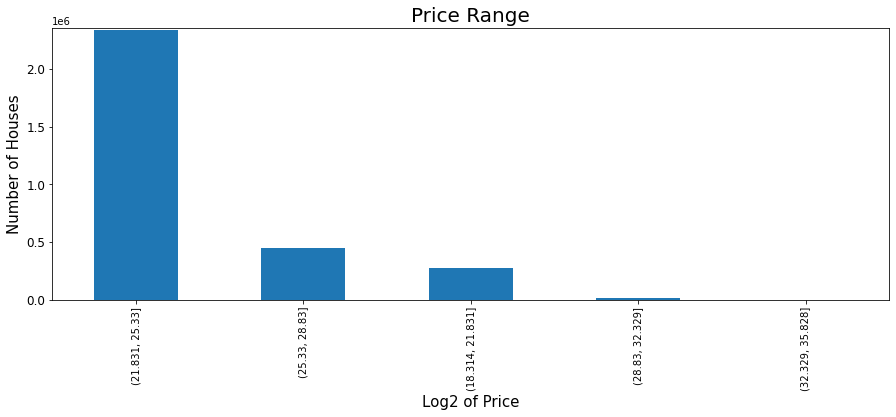

In [22]:
getPriceRange(5)

In [23]:
df.loc[df['TradePrice'] > 28.83]

,Type,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
43,Residential Land(Land and Building),1101,Hokkaido,"Chuo Ward,Sapporo City",Odoorinishi,Odori,1,1,31.932977,1900.0,False,1.0,False,Commercial Zone,800.0,2019,3
45,Residential Land(Land and Building),1101,Hokkaido,"Chuo Ward,Sapporo City",Odoorinishi,Odori,3,3,32.382780,2000.0,False,1.0,False,Commercial Zone,800.0,2017,4
62,Residential Land(Land and Building),1101,Hokkaido,"Chuo Ward,Sapporo City",Odoorinishi,Nishi 11-chome,3,3,31.382780,1700.0,False,1.0,False,Commercial Zone,400.0,2007,4
69,Residential Land(Land and Building),1101,Hokkaido,"Chuo Ward,Sapporo City",Odoorinishi,Nishi 11-chome,6,6,30.745350,850.0,False,1.0,False,Commercial Zone,600.0,2007,1
73,Residential Land(Land and Building),1101,Hokkaido,"Chuo Ward,Sapporo City",Odoorinishi,Nishi 11-chome,3,3,29.319586,810.0,False,1.0,False,Commercial Zone,600.0,2006,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3898895,Residential Land(Land and Building),47201,Okinawa Prefecture,Naha City,Shuriishiminecho,Shuri,24,24,29.184234,2000.0,False,1.0,False,Category I Exclusively Medium-high Residential...,200.0,2009,2
3902712,Residential Land(Land and Building),47201,Okinawa Prefecture,Naha City,Tsuboya,Asato,3,3,29.482315,2000.0,True,0.0,False,Neighborhood Commercial Zone,200.0,2007,2
3902785,Residential Land(Land and Building),47201,Okinawa Prefecture,Naha City,Maejima,Miebashi,4,4,29.882853,550.0,False,1.0,False,Commercial Zone,600.0,2008,4
3902813,Residential Land(Land Only),47201,Okinawa Prefecture,Naha City,Makishi,Miebashi,8,8,28.925922,1100.0,False,0.0,False,Category I Residential Zone,200.0,2007,4


From this, it appears that less than 0.5% is also above 28.83, these data would also be omitted

In [24]:
df = df.loc[df['TradePrice'] < 28.83]

# Knowing relationship between Prefectures and TradePrice

It appears that the dataset is right-skewed with the outliers removed. From this dataset, other columns would also be analyzed

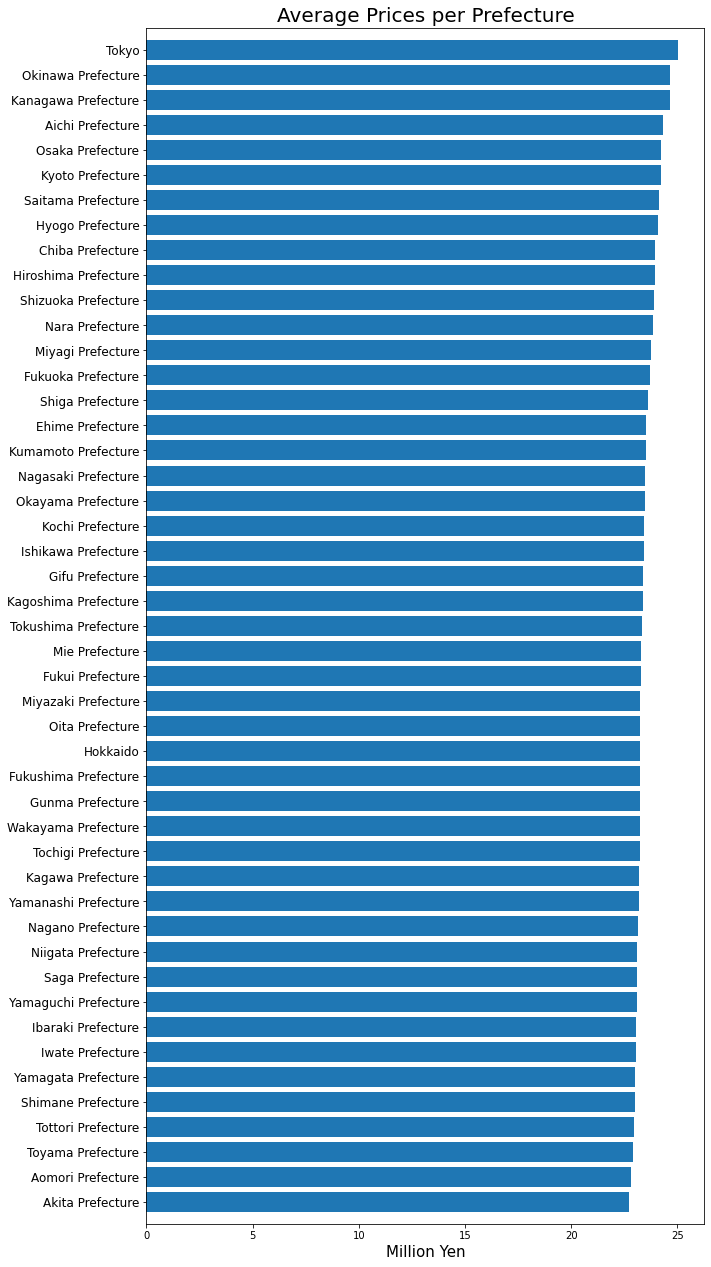

In [25]:
prefectureTP = df.groupby('Prefecture', as_index = False)['TradePrice'].mean().sort_values('TradePrice', ascending=False)
fig, ax = plt.subplots(figsize=(10,22))
ax.barh(prefectureTP['Prefecture'], prefectureTP['TradePrice'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title('Average Prices per Prefecture', fontsize=20)
plt.yticks(fontsize=12)
plt.show()

From the horizontal bar graph given, it appears that one of the driving factors for the price of a property is the location of the property itself. For further analysis, the different municipalities per prefecture would be compared if it also affects the mean price of a location

In [26]:
print(len(df['Municipality'].unique()))
print(len(df.loc[df['Prefecture'] == 'Tokyo']['Municipality'].unique()))

1461
51


As the total number of prefecture per Municipality is too high, a comparison between the average prices per Municipality would be compared know if location within a certain prefecture affects the price by a significant amount

In [27]:
for i, row in prefectureTP.iterrows():
    MuniTP = df.loc[df['Prefecture'] == row['Prefecture']].groupby('Municipality', 
                                                              as_index = False).mean().sort_values('TradePrice', ascending = False)
    prefectureTP.loc[prefectureTP['Prefecture'] == row['Prefecture'], 'min'] = MuniTP.min()['TradePrice']
    prefectureTP.loc[prefectureTP['Prefecture'] == row['Prefecture'], 'max'] = MuniTP.max()['TradePrice']

In [28]:
prefectureTP

,Prefecture,TradePrice,min,max
40,Tokyo,25.021690,23.930822,25.657379
31,Okinawa Prefecture,24.662932,23.391000,24.970350
18,Kanagawa Prefecture,24.652183,22.567875,25.412252
0,Aichi Prefecture,24.307212,22.225901,24.947793
32,Osaka Prefecture,24.233638,21.891036,24.801645
21,Kyoto Prefecture,24.220603,21.434510,24.766535
34,Saitama Prefecture,24.154750,21.819094,25.109971
12,Hyogo Prefecture,24.073960,20.779565,25.141022
3,Chiba Prefecture,23.932509,19.395869,25.391741
10,Hiroshima Prefecture,23.925470,22.365370,24.797409


With the table where the minimum and maximum is shown from the table, where the average prices of a prefecture can be widely different to the average prices of a municipality, the column *prefecture* would be dropped.

In [29]:
df.drop(columns=['Prefecture', 'MunicipalityCode'], inplace= True)
df.head()

,Type,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,26.357833,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,25.179496,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"Pre-owned Condominiums, etc.","Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,24.179496,95.0,False,0.0,False,Neighborhood Commercial Zone,200.0,2018,4
3,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,22.253497,290.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,24.575425,430.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2


# Removal of Insufficient Data

To further process the data, municipalities with only count of less than 100 will be removed.

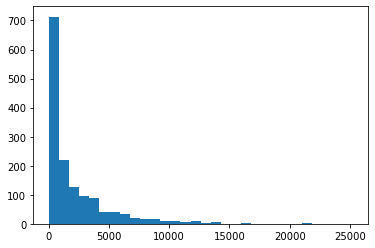

In [30]:
numMunicipality = df['Municipality'].value_counts(dropna=True, sort=True)
plt.hist(numMunicipality.values, bins=30)
plt.show()

In [31]:
for mncplt in numMunicipality.keys():
    if numMunicipality[mncplt] < 100:
        df.drop(df[df['Municipality'] == mncplt].index, inplace=True)
df.shape

(3042929, 15)

In [32]:
df['Type'].unique()

['Residential Land(Land Only)', 'Pre-owned Condominiums, etc.', 'Residential Land(Land and Building)']
Categories (5, object): ['Agricultural Land', 'Forest Land', 'Pre-owned Condominiums, etc.', 'Residential Land(Land Only)', 'Residential Land(Land and Building)']

# Checking relationship between TradePrice and Type

Moving to the *Type* column, there are three known categories. The average prices of each category would now be computed to see if there is a significant difference between the prices of these properties

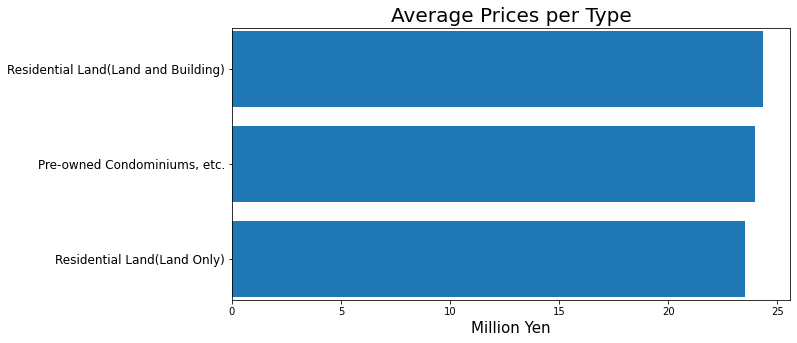

In [33]:
propertyType = df.groupby('Type', as_index = False).mean().sort_values('TradePrice', ascending = False)

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(propertyType['Type'], propertyType['TradePrice'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title(f'Average Prices per Type', fontsize=20)
plt.yticks(fontsize=12)
plt.show()

From the following, the type variable could prove useful in determining the price of a property, thus the *type* column would be hot-encoded as to make it easier for the model to use the data

In [34]:
TypeEncode = pd.get_dummies(df['Type'])
df = df.join(TypeEncode)
df.drop(columns=['Type', 'Forest Land', 'Agricultural Land'], inplace=True)
del TypeEncode

In [35]:
df.head(2)

,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter,"Pre-owned Condominiums, etc.",Residential Land(Land Only),Residential Land(Land and Building)
0,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,26.357833,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4,0,1,0
1,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,25.179496,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4,0,1,0


# Removing subset column and unneeded column

Moving onto the *DistrictName* column, as this column is only based from the Municipality itself, where-in the District is a location within a Municipality, further dividing each Municipality to districts would further diversify the data. This column would then be omitted

Furthermore, the column *NearestStation* could also be removed as it only describes what the name of the Station that is nearest to the location, the columns *MinTimeToNearestStation* and *MaxTimeToNearestStation* could have more valuable data compared to the column *NearestStation*.

In [36]:
df.drop(columns=['DistrictName', 'NearestStation'], inplace = True)

In [37]:
df.head(2)

,Municipality,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter,"Pre-owned Condominiums, etc.",Residential Land(Land Only),Residential Land(Land and Building)
0,"Chuo Ward,Sapporo City",28,28,26.357833,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4,0,1,0
1,"Chuo Ward,Sapporo City",27,27,25.179496,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4,0,1,0


# Hot-encoding of CityPlanning and Mean-encoding of Municipality

The number of unique values for the column *CityPlanning* is 16, the TradePrice mean of these unique values would be taken as to see if different CityPlanning categories can affect the price of a certain property.

In [38]:
len(df['CityPlanning'].unique())

16

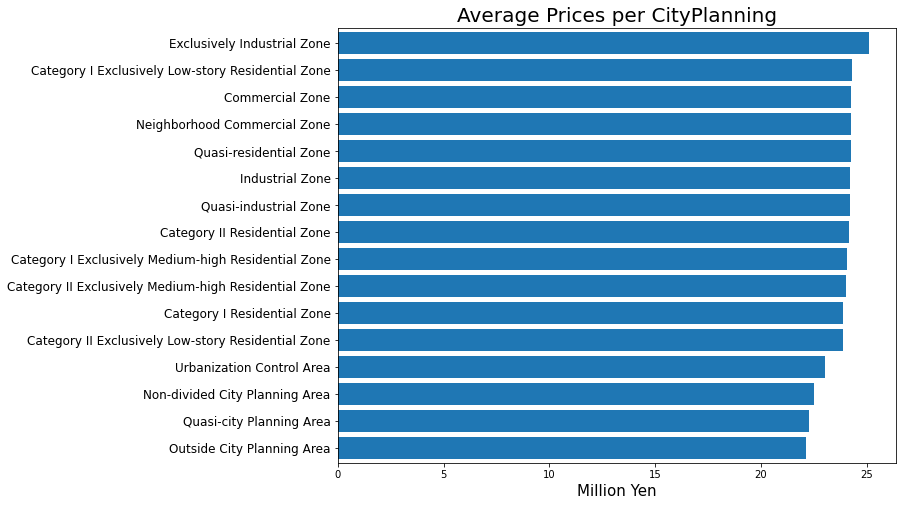

In [39]:
CityPlanningPrice = df.groupby('CityPlanning', as_index = False).mean().sort_values('TradePrice', ascending = False)

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(CityPlanningPrice['CityPlanning'], CityPlanningPrice['TradePrice'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title(f'Average Prices per CityPlanning', fontsize=20)
plt.yticks(fontsize=12)
plt.show()

In [40]:
CityPlanningPrice[['CityPlanning','TradePrice']]

,CityPlanning,TradePrice
7,Exclusively Industrial Zone,25.110728
0,Category I Exclusively Low-story Residential Zone,24.299582
6,Commercial Zone,24.251035
9,Neighborhood Commercial Zone,24.235817
14,Quasi-residential Zone,24.233860
8,Industrial Zone,24.219901
13,Quasi-industrial Zone,24.218862
5,Category II Residential Zone,24.173471
1,Category I Exclusively Medium-high Residential...,24.071887
4,Category II Exclusively Medium-high Residentia...,24.036258


In [41]:
del CityPlanningPrice

From the following table, it can be seen that the average prices can vary depending on the type of CityPlanning. Besides the *Exclusively Industrial Zone*, most CityPlanning are close to each other in terms of average TradePrice. To reduce the number of CityPlanning categories, some categories would be combined together.

From 16 different categories, it would be reduced down to 9 with the following grouped together.
- Outside City Planning Area
- Quasi-city Planning Area
- Non-divided City Planning Area
- Urbanization Control Area
- Category II Exclusively Low-story Residential Zone, Category I Residential Zone
- Category II Exclusively Medium-high Residential Zone, Category I Exclusively Medium-high Residential Zone
- Industrial Zone, Commercial Zone, Category II Residential Zone, Quasi-residential Zone, Quasi-industrial Zone
- Neighborhood Commercial Zone
- Category I Exclusively Low-story Residential Zone
- Exclusively Industrial Zone

The grouping done to the CityPlanning categories was done with their TradePrice being within the same average value within a million.

In [42]:
#Grouping of categories
df['CityPlanning'] = df['CityPlanning'].replace(['Category II Exclusively Low-story Residential Zone',
                                                 'Category I Residential Zone'], 'Residential Zone I')

df['CityPlanning'] = df['CityPlanning'].replace(['Category II Exclusively Medium-high Residential Zone',
                                                 'Category I Exclusively Medium-high Residential Zone'], 'Residential Zone II')

df['CityPlanning'] = df['CityPlanning'].replace(['Industrial Zone',
                                                 'Commercial Zone',
                                                 'Category II Residential Zone',
                                                 'Quasi-residential Zone',
                                                 'Quasi-industrial Zone'], 'Various Zones')


In [43]:
#Hot-encoding of CityPlanning Column
CityPlanningEncode = pd.get_dummies(df['CityPlanning'])
df = df.join(CityPlanningEncode)
df.drop(columns=['CityPlanning'], inplace=True)
del CityPlanningEncode

In [44]:
df.columns

Index(['Municipality', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
       'TradePrice', 'Area', 'FrontageIsGreaterFlag',
       'TotalFloorAreaIsGreaterFlag', 'PrewarBuilding', 'FloorAreaRatio',
       'Year', 'Quarter', 'Pre-owned Condominiums, etc.',
       'Residential Land(Land Only)', 'Residential Land(Land and Building)',
       'Category I Exclusively Low-story Residential Zone',
       'Exclusively Industrial Zone', 'Neighborhood Commercial Zone',
       'Non-divided City Planning Area', 'Outside City Planning Area',
       'Quasi-city Planning Area', 'Residential Zone I', 'Residential Zone II',
       'Urbanization Control Area', 'Various Zones'],
      dtype='object')

In [45]:
df.head(2)

,Municipality,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,FloorAreaRatio,Year,...,Category I Exclusively Low-story Residential Zone,Exclusively Industrial Zone,Neighborhood Commercial Zone,Non-divided City Planning Area,Outside City Planning Area,Quasi-city Planning Area,Residential Zone I,Residential Zone II,Urbanization Control Area,Various Zones
0,"Chuo Ward,Sapporo City",28,28,26.357833,1100.0,False,0.0,False,80.0,2018,...,1,0,0,0,0,0,0,0,0,0
1,"Chuo Ward,Sapporo City",27,27,25.179496,310.0,False,0.0,False,80.0,2018,...,1,0,0,0,0,0,0,0,0,0


From this, it appears that the only column that is not numerical is the Municipality (Categorical), FrontageIsGreaterFlag (boolean), PrewarBuilding (boolean). For both of the boolean columns, these would be converted to a binary integer of 0s and 1s. While for the Municipality column, as the number of categories is far too great to hot-encode, mean encoding would be done to the different municipalities.

Additionally, as the MinTime and MaxTime ToNearestStation column was initially set into 'string' as there were null values, these columns would also be transformed into an integer as to fit into the model

In [46]:
MuniMean = df.groupby(['Municipality'])['TradePrice'].mean().to_dict()
df['Municipality'] = df['Municipality'].map(MuniMean)
df['FrontageIsGreaterFlag'] = df['FrontageIsGreaterFlag'].astype(int)
df['PrewarBuilding'] = df['PrewarBuilding'].astype(int)
df['MinTimeToNearestStation'] = df['MinTimeToNearestStation'].astype(int)
df['MaxTimeToNearestStation'] = df['MaxTimeToNearestStation'].astype(int)
del MuniMean

In [47]:
df.head(2)

,Municipality,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,FloorAreaRatio,Year,...,Category I Exclusively Low-story Residential Zone,Exclusively Industrial Zone,Neighborhood Commercial Zone,Non-divided City Planning Area,Outside City Planning Area,Quasi-city Planning Area,Residential Zone I,Residential Zone II,Urbanization Control Area,Various Zones
0,24.181266,28,28,26.357833,1100.0,0,0.0,0,80.0,2018,...,1,0,0,0,0,0,0,0,0,0
1,24.181266,27,27,25.179496,310.0,0,0.0,0,80.0,2018,...,1,0,0,0,0,0,0,0,0,0


# Model Creation and Testing

Now that all of the columns are numerical, the data would now be split into two a training set and a test set. Additionally, the TradePrice column would be removed from the table and be put onto another table.

The model used would be a XGBoost

In [48]:
x = df.copy()
y = x['TradePrice']
x.drop(columns=['TradePrice', 'MaxTimeToNearestStation', 'Quarter'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 30, stratify=x['Municipality'])
x_train = np.asarray(x_train).tolist()
y_train = np.asarray(y_train).tolist()
x_test = np.asarray(x_test).tolist()
y_test = np.asarray(y_test).tolist()

In [49]:
x.columns

Index(['Municipality', 'MinTimeToNearestStation', 'Area',
       'FrontageIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag',
       'PrewarBuilding', 'FloorAreaRatio', 'Year',
       'Pre-owned Condominiums, etc.', 'Residential Land(Land Only)',
       'Residential Land(Land and Building)',
       'Category I Exclusively Low-story Residential Zone',
       'Exclusively Industrial Zone', 'Neighborhood Commercial Zone',
       'Non-divided City Planning Area', 'Outside City Planning Area',
       'Quasi-city Planning Area', 'Residential Zone I', 'Residential Zone II',
       'Urbanization Control Area', 'Various Zones'],
      dtype='object')

In [50]:
linear_reg = linear_model.LinearRegression()

In [51]:
linear_reg.fit(x_train,y_train)

LinearRegression()

In [52]:
linear_preds = linear_reg.predict(x_test)
print(mean_absolute_error(y_test, linear_preds)*100)

80.7166991011173


In [53]:
linear_reg.coef_

array([ 1.12406749e+00, -8.86916974e-03,  1.89733394e-03, -3.37358107e-01,
        8.10777705e-01, -6.10953988e-01,  7.49822032e-04, -8.66792081e-03,
       -3.94872225e-01, -1.62459863e-01,  5.57332088e-01,  4.08520253e-01,
        7.70489107e-02,  4.22325859e-01, -1.97435356e-01, -8.21903336e-01,
       -4.07599742e-01,  2.90245431e-01,  3.63600281e-01, -5.48000402e-01,
        4.13198102e-01])

Conversion of Actual and Predicted Values back to its original values

In [54]:
y_testActual = np.exp2(y_test)
linear_predsActual = np.exp2(linear_preds)

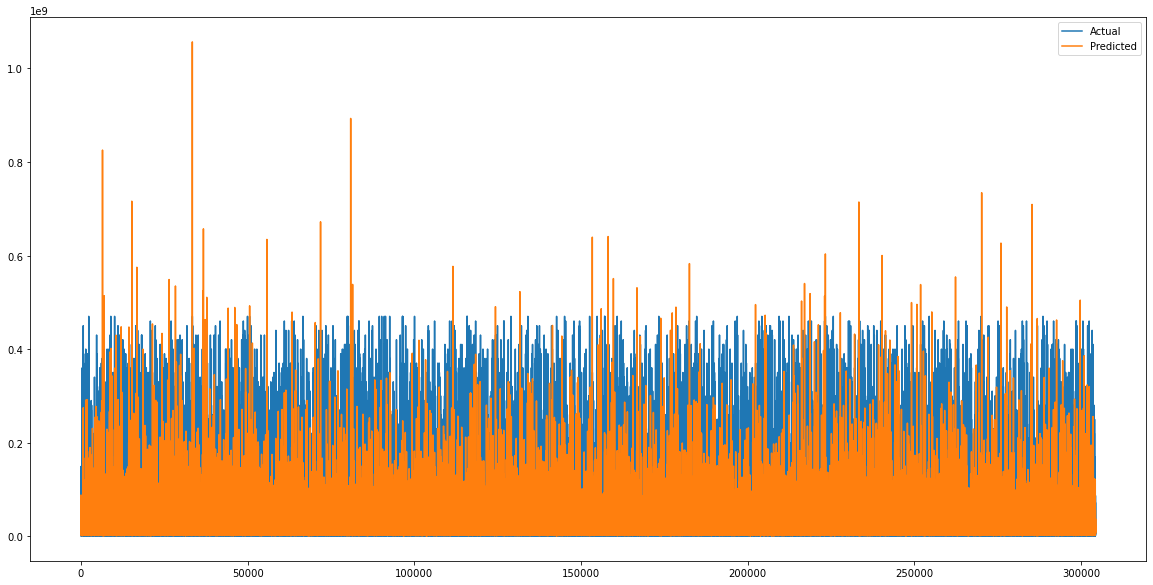

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(y_testActual, label="Actual")
ax.plot(linear_predsActual, label="Predicted")
ax.legend()
plt.show()

In [56]:
df

,Municipality,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,FloorAreaRatio,Year,...,Category I Exclusively Low-story Residential Zone,Exclusively Industrial Zone,Neighborhood Commercial Zone,Non-divided City Planning Area,Outside City Planning Area,Quasi-city Planning Area,Residential Zone I,Residential Zone II,Urbanization Control Area,Various Zones
0,24.181266,28,28,26.357833,1100.0,0,0.0,0,80.0,2018,...,1,0,0,0,0,0,0,0,0,0
1,24.181266,27,27,25.179496,310.0,0,0.0,0,80.0,2018,...,1,0,0,0,0,0,0,0,0,0
2,24.181266,20,20,24.179496,95.0,0,0.0,0,200.0,2018,...,0,0,1,0,0,0,0,0,0,0
3,24.181266,26,26,22.253497,290.0,0,0.0,0,80.0,2018,...,1,0,0,0,0,0,0,0,0,0
4,24.181266,23,23,24.575425,430.0,0,0.0,0,80.0,2018,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902887,24.665954,11,11,24.101494,100.0,0,0.0,0,200.0,2007,...,0,0,0,0,0,0,0,0,0,1
3902888,24.665954,11,11,23.738923,80.0,0,0.0,0,200.0,2007,...,0,0,0,0,0,0,0,0,0,1
3902889,24.665954,11,11,22.984680,45.0,0,0.0,0,200.0,2007,...,0,0,0,0,0,0,0,0,0,1
3902890,24.665954,10,10,25.862306,280.0,0,0.0,0,400.0,2007,...,0,0,0,0,0,0,0,0,0,1


In [57]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(300,), activation='relu', solver='adam', max_iter = 500)
mlp_reg.fit(x_train,y_train)

MLPRegressor(hidden_layer_sizes=(300,), max_iter=500)

In [59]:
mlp_preds = mlp_reg.predict(x_test)
print(mean_absolute_error(y_test, mlp_preds)*100)

68.81804096887468


In [61]:
mlp_regActual = np.exp2(mlp_preds)

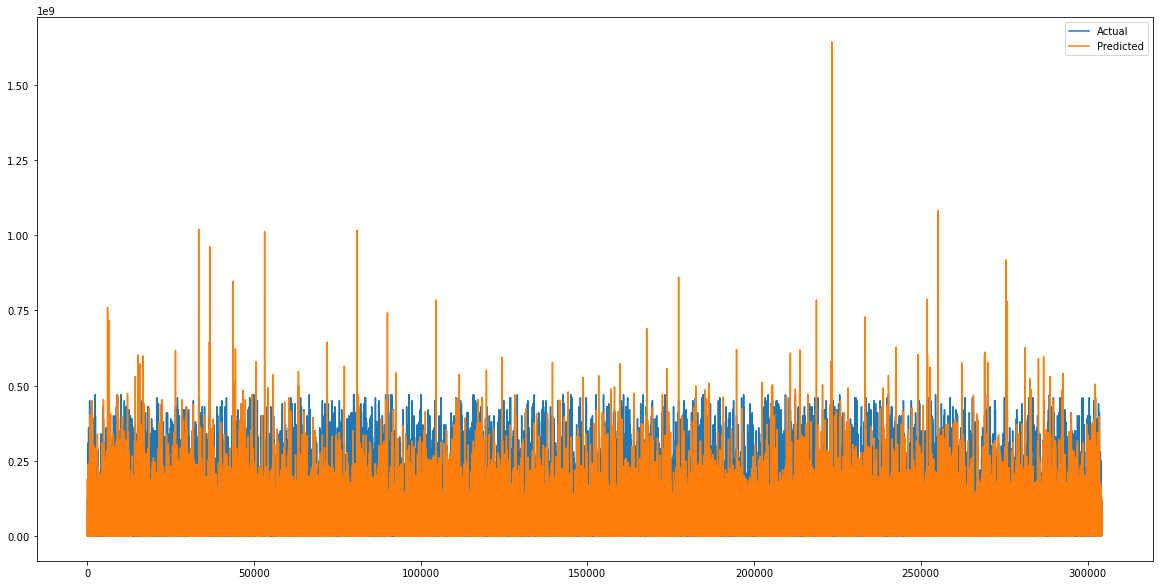

In [62]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(y_testActual, label="Actual")
ax.plot(mlp_regActual, label="Predicted")
ax.legend()
plt.show()

In [63]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 1000, subsample=0.7)

In [64]:
xgb_reg.fit(x_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, ...)

In [65]:
xgb_preds = xgb_reg.predict(x_test)

In [66]:
print(mean_absolute_error(y_test, xgb_preds)*100)

63.674217637169725


In [67]:
xgb_predsActual = np.exp2(xgb_preds)

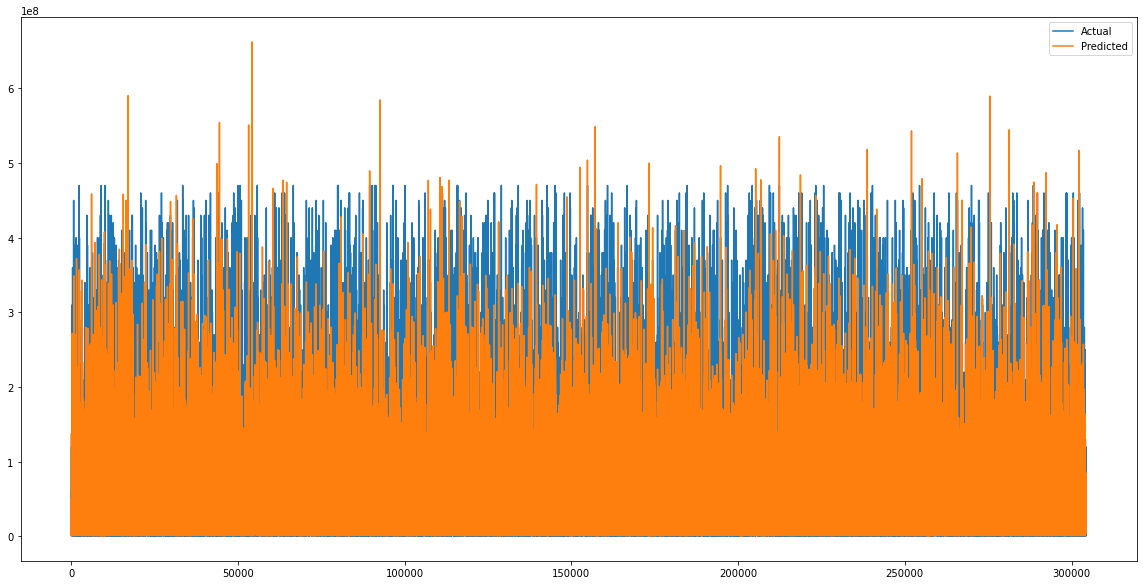

In [68]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(y_testActual, label="Actual")
ax.plot(xgb_predsActual, label="Predicted")
ax.legend()
plt.show()